<a href="https://colab.research.google.com/github/robimalco/colab/blob/main/Home_Credit_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADD KEYS

In [2]:
!rm -rf *

import os
os.environ['KAGGLE_USERNAME'] = "robimalco"
os.environ['KAGGLE_KEY'] = "6e1b0ae031fab7836f95acee67a8c67e"
!pip install -q kaggle
!kaggle competitions download -c home-credit-default-risk

  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 14.0MB/s]
 58% 33.0M/56.8M [00:00<00:00, 119MB/s]
100% 56.8M/56.8M [00:00<00:00, 144MB/s]
 94% 72.0M/76.3M [00:00<00:00, 49.7MB/s]
100% 76.3M/76.3M [00:00<00:00, 91.6MB/s]
  0% 0.00/5.81M [00:00<?, ?B/s]
100% 5.81M/5.81M [00:00<00:00, 53.6MB/s]
 88% 96.0M/109M [00:01<00:00, 51.9MB/s]
100% 109M/109M [00:01<00:00, 64.4MB/s] 
 97% 262M/271M [00:02<00:00, 90.8MB/s]
100% 271M/271M [00:02<00:00, 128MB/s] 
  0% 0.00/524k [00:00<?, ?B/s]
100% 524k/524k [00:00<00:00, 164MB/s]
 91% 33.0M/36.1M [00:00<00:00, 35.9MB/s]
100% 36.1M/36.1M [00:00<00:00, 67.0MB/s]
 46% 17.0M/36.8M [00:00<00:00, 42.8MB/s]
100% 36.8M/36.8M [00:00<00:00, 83.0MB/s]
 95% 92.0M/96.7M [00:01<00:00, 68.8MB/s]
100% 96.7M/96.7M [00:01<00:00, 95.2MB/s]


# START SETUP

In [ ]:
!unzip application_test.csv.zip
!unzip application_train.csv.zip
!unzip previous_application.csv.zip
# !unzip POS_CASH_balance.csv.zip
# !unzip bureau.csv.zip
# !unzip bureau_balance.csv.zip
# !unzip credit_card_balance.csv.zip
# !unzip installments_payments.csv.zip

In [ ]:
!pip install torch==1.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install featuretools

import numpy as np
import pandas as pd
import gc

import datetime
import random
import string

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

import featuretools as ft

from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('mode.chained_assignment', None)

In [ ]:
!pip install --upgrade gspread
from google.colab import auth, drive
import gspread
from oauth2client.client import GoogleCredentials
drive.mount('/drive')
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1M-CqsTbBu7ScY4mZBcpI8kPbI7F-BE8aPTC4UknumYk/edit#gid=0')
sheet = wb.worksheet('Data')
def get_next_row(worksheet):
    str_list = list(filter(None, worksheet.col_values(1)))
    return str(len(str_list)+1)

# UTILITIES

In [7]:
def generate_timestamp():
  now = datetime.datetime.now()
  year = '{:02d}'.format(now.year)
  month = '{:02d}'.format(now.month)
  day = '{:02d}'.format(now.day)
  hour = '{:02d}'.format(now.hour)
  minute = '{:02d}'.format(now.minute)
  return '{}-{}-{} {}:{}'.format(year, month, day, hour, minute)

In [8]:
def order_columns_alphabetically(input_df):
  input_df_columns = list(input_df.columns)
  input_df_columns.sort()
  return input_df[input_df_columns]

In [9]:
def smart_overview(input_df):
  a_types = []
  a_countUnique = []
  a_missing = []
  a_missing_perc = []
  a_corrTarget = []
  a_min = []
  a_max = []
  a_mean = []
  a_median = []
  a_quantile = []
  for column in input_df.columns:
    x = input_df[column]
    x_type = input_df.dtypes[column]
    countUnique = len(x.unique())
    missing = x.isnull().sum()
    missing_perc = round((missing/input_df.shape[0]),3)*100
    if x_type == np.int64 or x_type == np.float64:
      if 'TARGET' in input_df.columns:
        a_corrTarget.append(round(x.corr(input_df['TARGET']), 3))
      else:
        a_corrTarget.append('/')
      a_min.append(x.min())
      a_max.append(x.max())
      a_mean.append(x.mean())
      a_median.append(x.median())
      a_quantile.append(x.quantile(0.5))
    else:
      a_corrTarget.append('')
      a_min.append('')
      a_max.append('')
      a_mean.append('')
      a_median.append('')
      a_quantile.append('')
    a_types.append(x_type)
    a_countUnique.append(countUnique)
    a_missing.append(missing)
    a_missing_perc.append(missing_perc)
  explore_df = pd.DataFrame({
    'Columns': input_df.columns,
    'Types': a_types,
    'Unique': a_countUnique,
    'Missing': a_missing,
    'Missing%': a_missing_perc,
    'CorrTarget': a_corrTarget,
    'Min': a_min,
    'Max': a_max,
    'Mean': a_mean,
    'Median': a_median,
    'Quantile': a_quantile
  })
  explore_df.set_index('Columns', inplace=True)
  return explore_df.transpose()

# Notes

In [ ]:
# application_{train|test}.csv --> main table, static data for all applications. One row represents one loan in our data sample.
# bureau.csv --> client's previous credits, for every loan in our sample, there are as many rows as number of credits the client had.
# bureau_balance.csv --> monthly balances of previous credits, one row for each month.
# POS_CASH_balance.csv --> monthly balance snapshots of previous point of sales and cash loans that the applicant had, one row for each month.
# credit_card_balance.csv --> monthly balance snapshots of previous credit cards, one row for each month.
# previous_application.csv --> all previous applications for Home Credit loans of clients who have loans.
# installments_payments.csv --> repayment history for the previously disbursed credits.

columns_descriptions_df = pd.read_csv('HomeCredit_columns_description.csv', engine='python')
# columns_descriptions_df[columns_descriptions_df['Table'] == 'previous_application.csv'].sort_values(by=['Row'])

- The number of hidden neurons should be between the size of the input layer and the size of the output layer.					
- The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.					
- The number of hidden neurons should be less than twice the size of the input layer.
- I = 2000
- H = 1321
- O = 1

# SET HYPERPARAMETERS

In [10]:
hp_test_size = 0.2
hp_emb_drop = 0.04
hp_layers = [800, 350]
hp_ps = [0.001,0.01]
hp_lr= 0.001
hp_epochs = 4

# LOAD DATA

In [42]:
application_train_df = pd.read_csv('application_train.csv').sample(frac = 1)
application_test_df = pd.read_csv('application_test.csv')
previous_application_df = pd.read_csv('previous_application.csv')
# bureau_df = pd.read_csv('bureau.csv')
# bureau_balance_df = pd.read_csv('bureau_balance.csv')
# pos_cash_balance_df = pd.read_csv('POS_CASH_balance.csv')
# credit_card_balance_df = pd.read_csv('credit_card_balance.csv')
# installments_payments_df = pd.read_csv('installments_payments.csv')

In [43]:
application_train_df['CSV_SOURCE'] = 'application_train.csv'
application_test_df['CSV_SOURCE'] = 'application_test.csv'
df = pd.concat([application_train_df, application_test_df])

In [44]:
numerical_columns = list(df.select_dtypes(include=[np.int64, np.float64]).columns)
categorical_columns = list(df.select_dtypes(include=[np.object]).columns)

# for numerical_column in numerical_columns:
#  df[numerical_column].fillna(value=df[numerical_column].median(), inplace=True)

# for categorical_column in categorical_columns:
#  df[categorical_column].fillna('NULL', inplace=True)

# FEATURETOOLS

In [45]:
es = ft.EntitySet('application_data')

In [46]:
es.entity_from_dataframe(
    entity_id='apps',
    dataframe=df.drop('TARGET', axis=1),
    index='SK_ID_CURR',
    variable_types={
        f: ft.variable_types.Categorical 
        for f in df.columns if f.startswith('FLAG_')
    }
)

Entityset: application_data
  Entities:
    apps [Rows: 356255, Columns: 122]
  Relationships:
    No relationships

In [47]:
today = pd.to_datetime('2020-11-30')
previous_application_df['DAYS_DECISION'] = today + pd.to_timedelta(previous_application_df['DAYS_DECISION'], unit='d')

es = es.entity_from_dataframe(
    entity_id = 'prev_apps', 
    dataframe = previous_application_df,
    index = 'SK_ID_PREV',
    time_index = 'DAYS_DECISION',
    variable_types={
        f: ft.variable_types.Categorical 
        for f in previous_application_df.columns if f.startswith('NFLAG_')
    }
)

In [48]:
r_app_cur_to_app_prev = ft.Relationship(
    es['apps']['SK_ID_CURR'],
    es['prev_apps']['SK_ID_CURR']
)

es = es.add_relationship(r_app_cur_to_app_prev)

es

Entityset: application_data
  Entities:
    apps [Rows: 356255, Columns: 122]
    prev_apps [Rows: 1670214, Columns: 37]
  Relationships:
    prev_apps.SK_ID_CURR -> apps.SK_ID_CURR

In [49]:
%%time

cutoff_times = pd.DataFrame(df.SK_ID_CURR)
cutoff_times['time'] = today

# add last_time_index
es.add_last_time_indexes()

CPU times: user 500 ms, sys: 5.98 ms, total: 506 ms
Wall time: 511 ms


In [ ]:
feature_defs = ft.dfs(
  entityset=es, 
  target_entity="apps", 
  features_only=True,
  max_depth=1,
  cutoff_time=cutoff_times,
  training_window=ft.Timedelta(60, "d"), # use only last X days in computations
  max_features=1000,
  chunk_size=10000,
  verbose=True,
)

# check what's been created so far
feature_defs

In [51]:
fm, feature_defs = ft.dfs(
  entityset=es, 
  target_entity="apps",
  max_depth=1,
  cutoff_time=cutoff_times,
  training_window=ft.Timedelta(60, "d"),
  max_features=1000,
  chunk_size=4000,
  verbose=True,
)

Built 254 features
Elapsed: 04:00 | Progress: 100%|██████████


In [52]:
fm = ft.selection.remove_highly_null_features(fm)
fm = ft.selection.remove_low_information_features(fm)
fm = ft.selection.remove_single_value_features(fm)
fm = fm.drop_duplicates()

# MANAGE MISSING VALUES

In [53]:
numerical_columns = list(fm.select_dtypes(include=[np.int64, np.float64]).columns)
categorical_columns = list(fm.select_dtypes(include=[np.object]).columns)

In [54]:
def variance_threshold_select(df, thresh):
  df1 = df.copy(deep=True)
  selector = VarianceThreshold(thresh)
  selector.fit(df1)
  df2 = df.loc[:,selector.get_support(indices=False)]
  return df2

In [69]:
df = variance_threshold_select(fm[numerical_columns], 0.99)

In [70]:
df = df.join(fm[categorical_columns])

In [1]:
null_df = pd.DataFrame(df.isnull().sum()).reset_index()
null_df.columns = ['column_name', 'amount_null']
null_df['column_name'].columns

NameError: ignored

In [81]:
df

,column_name,amount_null
0,AMT_INCOME_TOTAL,0
1,AMT_CREDIT,0
2,AMT_ANNUITY,36
3,AMT_GOODS_PRICE,278
4,DAYS_BIRTH,0
5,DAYS_EMPLOYED,0
6,DAYS_REGISTRATION,0
7,DAYS_ID_PUBLISH,0
8,OWN_CAR_AGE,235241
9,HOUR_APPR_PROCESS_START,0


In [76]:
ciao = pd.merge([df, null])

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,36
AMT_GOODS_PRICE,278
DAYS_BIRTH,0
DAYS_EMPLOYED,0
DAYS_REGISTRATION,0
DAYS_ID_PUBLISH,0
OWN_CAR_AGE,235241
HOUR_APPR_PROCESS_START,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde535c8390>,
      dtype=object)

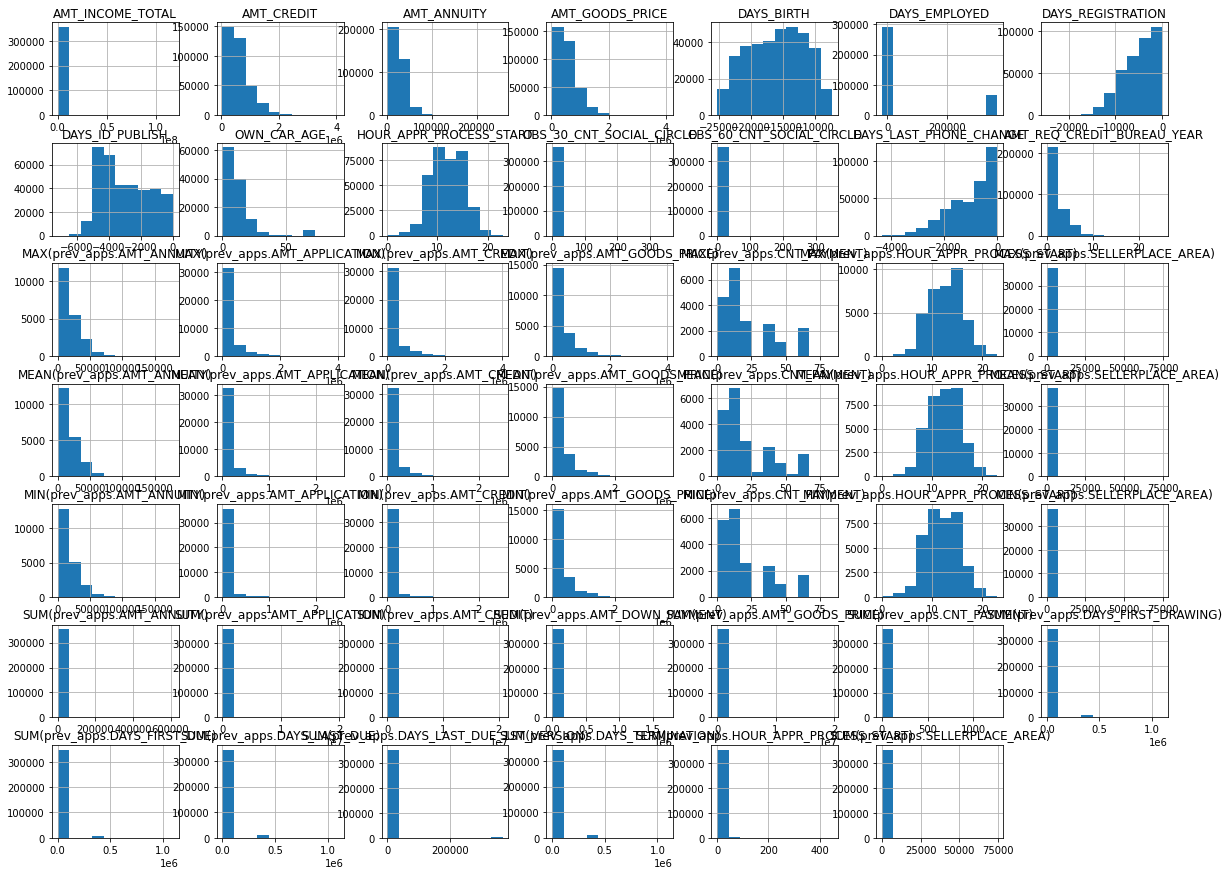

In [72]:
df.hist(figsize=(20,15))

In [104]:
numerical_columns = list(df.select_dtypes(include=[np.int64, np.float64]).columns)
categorical_columns = list(df.select_dtypes(include=[np.object]).columns)

In [94]:
# del fm, application_test_df, application_train_df
# gc.collect()

In [108]:
for numerical_column in numerical_columns:
  df[numerical_column].fillna(value=df[numerical_column].median(), inplace=True)

# for categorical_column in categorical_columns:
#  df[categorical_column].fillna('NULL', inplace=True)

# STANDARDISE

In [80]:
min_max_scaler = preprocessing.MinMaxScaler()
df[numerical_columns] = pd.DataFrame(min_max_scaler.fit_transform(df[numerical_columns]))

# CONVERT CATEGORICAL COLUMNS INTO TYPE "CATEGORY"

In [105]:
categorical_columns.remove('CSV_SOURCE')

for column in categorical_columns:
  df[column] = LabelEncoder().fit_transform(df[column].astype(str))
  df[column] = df[column].astype('category')

In [109]:
smart_overview(df)

Columns,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,MAX(prev_apps.AMT_ANNUITY),MAX(prev_apps.AMT_APPLICATION),MAX(prev_apps.AMT_CREDIT),MAX(prev_apps.AMT_GOODS_PRICE),MAX(prev_apps.CNT_PAYMENT),MAX(prev_apps.HOUR_APPR_PROCESS_START),MAX(prev_apps.SELLERPLACE_AREA),MEAN(prev_apps.AMT_ANNUITY),MEAN(prev_apps.AMT_APPLICATION),MEAN(prev_apps.AMT_CREDIT),MEAN(prev_apps.AMT_GOODS_PRICE),MEAN(prev_apps.CNT_PAYMENT),MEAN(prev_apps.HOUR_APPR_PROCESS_START),MEAN(prev_apps.SELLERPLACE_AREA),MIN(prev_apps.AMT_ANNUITY),MIN(prev_apps.AMT_APPLICATION),MIN(prev_apps.AMT_CREDIT),MIN(prev_apps.AMT_GOODS_PRICE),MIN(prev_apps.CNT_PAYMENT),MIN(prev_apps.HOUR_APPR_PROCESS_START),MIN(prev_apps.SELLERPLACE_AREA),MODE(prev_apps.NFLAG_LAST_APPL_IN_DAY),NUM_UNIQUE(prev_apps.CHANNEL_TYPE),NUM_UNIQUE(prev_apps.CODE_REJECT_REASON),NUM_UNIQUE(prev_apps.FLAG_LAST_APPL_PER_CONTRACT),NUM_UNIQUE(prev_apps.NAME_CASH_LOAN_PURPOSE),NUM_UNIQUE(prev_apps.NAME_CLIENT_TYPE),NUM_UNIQUE(prev_apps.NAME_CONTRACT_STATUS),NUM_UNIQUE(prev_apps.NAME_CONTRACT_TYPE),NUM_UNIQUE(prev_apps.NAME_GOODS_CATEGORY),NUM_UNIQUE(prev_apps.NAME_PAYMENT_TYPE),NUM_UNIQUE(prev_apps.NAME_PORTFOLIO),NUM_UNIQUE(prev_apps.NAME_PRODUCT_TYPE),NUM_UNIQUE(prev_apps.NAME_SELLER_INDUSTRY),NUM_UNIQUE(prev_apps.NAME_TYPE_SUITE),NUM_UNIQUE(prev_apps.NAME_YIELD_GROUP),NUM_UNIQUE(prev_apps.NFLAG_INSURED_ON_APPROVAL),NUM_UNIQUE(prev_apps.NFLAG_LAST_APPL_IN_DAY),NUM_UNIQUE(prev_apps.PRODUCT_COMBINATION),NUM_UNIQUE(prev_apps.WEEKDAY_APPR_PROCESS_START),SUM(prev_apps.AMT_ANNUITY),SUM(prev_apps.AMT_APPLICATION),SUM(prev_apps.AMT_CREDIT),SUM(prev_apps.AMT_DOWN_PAYMENT),SUM(prev_apps.AMT_GOODS_PRICE),SUM(prev_apps.CNT_PAYMENT),SUM(prev_apps.DAYS_FIRST_DRAWING),SUM(prev_apps.DAYS_FIRST_DUE),SUM(prev_apps.DAYS_LAST_DUE),SUM(prev_apps.DAYS_LAST_DUE_1ST_VERSION),SUM(prev_apps.DAYS_TERMINATION),SUM(prev_apps.HOUR_APPR_PROCESS_START),SUM(prev_apps.SELLERPLACE_AREA),NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,CSV_SOURCE,FLAG_OWN_CAR,FLAG_OWN_REALTY,MODE(prev_apps.CHANNEL_TYPE),MODE(prev_apps.CODE_REJECT_REASON),MODE(prev_apps.FLAG_LAST_APPL_PER_CONTRACT),MODE(prev_apps.NAME_CASH_LOAN_PURPOSE),MODE(prev_apps.NAME_CLIENT_TYPE),MODE(prev_apps.NAME_CONTRACT_STATUS),MODE(prev_apps.NAME_CONTRACT_TYPE),MODE(prev_apps.NAME_GOODS_CATEGORY),MODE(prev_apps.NAME_PAYMENT_TYPE),MODE(prev_apps.NAME_PORTFOLIO),MODE(prev_apps.NAME_PRODUCT_TYPE),MODE(prev_apps.NAME_SELLER_INDUSTRY),MODE(prev_apps.NAME_YIELD_GROUP),MODE(prev_apps.PRODUCT_COMBINATION),MODE(prev_apps.WEEKDAY_APPR_PROCESS_START)
Types,float64,float64,float64,float64,int64,int64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,category,category,category,category,category,category,category,category,category,category,category,category,category,category,object,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category
Unique,2741,6480,14166,1291,17467,12896,15898,6224,63,18,24,36,35,3846,25,15329,8019,10523,8018,24,24,657,16708,9844,13252,9425,174,415,1239,14707,7323,8585,8066,23,24,624,2,4,4,2,4,3,4,3,4,4,4,3,3,4,4,3,2,7,7,167

# SPLIT DATA INTO TRAINING vs TRAIN

In [110]:
train_df = df[df['CSV_SOURCE'] == 'application_train.csv']
# train_df = df[df['CSV_SOURCE'] == 1]
train_output_df = pd.DataFrame(application_train_df['TARGET'], columns=['TARGET'])

test_df = df[df['CSV_SOURCE'] == 'application_test.csv']
# test_df = df[df['CSV_SOURCE'] == 0]

# REMOVE NOT USEFUL COLUMNS

In [111]:
train_df.drop(columns=['CSV_SOURCE'], axis=0, inplace=True)
test_df.drop(columns=['CSV_SOURCE'], axis=0, inplace=True)

# CREATE VALIDATION SET

In [112]:
x_train, x_validation, y_train, y_validation = train_test_split(train_df, train_output_df, test_size=hp_test_size, random_state=42)

# CREATE TENSORS

In [113]:
def create_tensors(input_df):
  stack = []
  for column in input_df.columns:
    if input_df.dtypes[column] == np.int64 or input_df.dtypes[column] == np.float64:
      stack.append(input_df[column].astype(np.float64))
    else:
      stack.append(input_df[column].cat.codes.values)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)

tensor_x_train_cat = create_tensors(x_train[categorical_columns]).float().to(device)
tensor_x_train_num = create_tensors(x_train[numerical_columns]).float().to(device)
tensor_y_train = torch.tensor(y_train.values).flatten().float().to(device)

tensor_x_valid_cat = create_tensors(x_validation[categorical_columns]).float().to(device)
tensor_x_valid_num = create_tensors(x_validation[numerical_columns]).float().to(device)
tensor_y_valid = torch.tensor(y_validation.values).flatten().float().to(device)

tensor_x_test_cat = create_tensors(test_df[categorical_columns]).float().to(device)
tensor_x_test_num = create_tensors(test_df[numerical_columns]).float().to(device)

# CREATE CATEGORICAL EMBEDDING SIZES

In [116]:
categorical_columns_size = [len(df[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size + 1) // 2)) for col_size in categorical_columns_size]

# CREATE PYTORCH DATA LOADER

In [117]:
train_tensor_dataset = TensorDataset(tensor_x_train_cat, tensor_x_train_num, tensor_y_train)
train_loader = DataLoader(dataset=train_tensor_dataset, batch_size=16, shuffle=True)

# DEFINE NEURAL NETWORK MODEL

![](https://yashuseth.files.wordpress.com/2018/07/model1.png)


In [118]:
class Model(nn.Module):
  def __init__(self, embedding_size, input_size, num_numerical_cols, layers, ps):
    super().__init__()

    self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
    self.emb_drop = nn.Dropout(hp_emb_drop)

    self.bn_cont = nn.BatchNorm1d(num_numerical_cols)

    layerlist = []
    for i, elem in enumerate(layers):
      layerlist.append(nn.Linear(input_size, elem))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(layers[i]))
      layerlist.append(nn.Dropout(ps[i]))
      input_size = elem
    layerlist.append(nn.Linear(layers[-1], 1))

    self.layers = nn.Sequential(*layerlist)

  def forward(self, x_c, x_n):

    embeddings = [e(x_c[:,i].long()) for i, e in enumerate(self.all_embeddings)]

    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)

    x_n = self.bn_cont(x_n)

    x = torch.cat([x, x_n], 1)
    x = self.layers(x)

    return x

# INSTANTIATE NEURAL NETWORK MODEL

In [119]:
num_numerical_cols = tensor_x_train_num.shape[1]

num_categorical_cols = sum((nf for ni, nf in categorical_embedding_sizes))
initial_input_size = num_categorical_cols + num_numerical_cols

model = Model(categorical_embedding_sizes, initial_input_size, num_numerical_cols, layers=hp_layers, ps=hp_ps)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hp_lr)
model.to(device)
tot_losses = []

# TRAIN NEURAL NETWORK MODEL

In [120]:
hp_epochs = 1

epoch: 0	loss: 0.2379897630275551


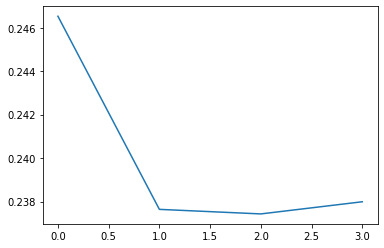

In [124]:
start_training = generate_timestamp()

model.train()

for epoch in range(hp_epochs):
  train_losses = []
  for x_cat, x_num, y in train_loader:
    y_pred = model(x_cat, x_num)
    single_loss = torch.sqrt(loss_function(y_pred.squeeze(), y))
    optimizer.zero_grad()
    single_loss.backward() 
    optimizer.step()
    train_losses.append(single_loss.item())
  epoch_loss = 1.0 * sum(train_losses) / len(train_losses)
  tot_losses.append(epoch_loss)
  print("epoch: " + str(epoch) + "\tloss: " + str(epoch_loss))
plt.plot(tot_losses)
plt.show()

last_train_loss = epoch_loss
end_training = generate_timestamp()

# VALIDATE NEURAL NETWORK

In [125]:
validation_tensor_dataset = TensorDataset(tensor_x_valid_cat, tensor_x_valid_num, tensor_y_valid)
validation_loader = DataLoader(dataset=validation_tensor_dataset, batch_size=16, shuffle=True)

valid_losses = []

model.eval()

with torch.no_grad():
  for x_cat, x_num, y in validation_loader:
    y_valid = model(x_cat, x_num)
    validation_loss = torch.sqrt(loss_function(y_valid.squeeze(), y))
    valid_losses.append(validation_loss.item())
  valid_loss = round(1.0 * sum(valid_losses) / len(valid_losses), 5)
  print("loss: " + str(valid_loss))

loss: 0.71167


# MAKE PREDICTIONS

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bd224cdd8>]],
      dtype=object)

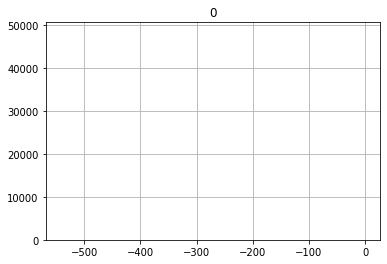

In [126]:
model.eval()

with torch.no_grad():
  y_test = model(tensor_x_test_cat, tensor_x_test_num)
pd.DataFrame(y_test).astype("float").hist(bins=1000)

In [129]:
y_test.min()

tensor(-541.8592, device='cuda:0')

# SAVE PREDICTIONS

In [130]:
prediction_id = ''.join(random.choice(string.ascii_uppercase + string.digits) for i in range(8))
prediction_df = pd.DataFrame(y_test).astype("float")
x_scaled = min_max_scaler.fit_transform(prediction_df)
prediction_df = pd.DataFrame(x_scaled)
prediction_df = pd.concat([prediction_df, application_test_df['SK_ID_CURR']], axis=1)
prediction_df.columns = ['TEMP_TARGET', 'SK_ID_CURR']
prediction_df['TARGET'] = prediction_df['TEMP_TARGET']
prediction_df = prediction_df[['SK_ID_CURR', 'TARGET']]
prediction_df.to_csv('/drive/My Drive/pycharm_colab_training/kaggle/HomeCreditDefaultRisk/submissions/' + prediction_id + '.csv', index=False)
test_target_mean = str(round(prediction_df['TARGET'].mean(), 3))
test_distrbution = prediction_df.groupby(by=['TARGET'])['TARGET'].count()
print("test_target_mean:", test_target_mean)
print(test_distrbution.to_string(header=False))

test_target_mean: 1.0
0.00000    1
0.68385    1
0.79325    1
0.79349    1
0.80678    1
0.81279    1
0.82966    1
0.85135    1
0.86601    1
0.88400    1
0.90634    1
0.91547    1
0.92196    1
0.92657    1
0.92767    1
0.93153    1
0.93168    1
0.93310    1
0.93686    1
0.93881    1
0.94109    1
0.94334    1
0.94561    1
0.94600    1
0.95005    1
0.95235    1
0.95343    1
0.95440    1
0.95473    1
0.95538    1
0.95564    1
0.95997    1
0.96084    1
0.96088    1
0.96192    1
0.96221    1
0.96277    1
0.96402    1
0.96530    1
0.96549    1
0.96571    1
0.96600    1
0.96637    1
0.96639    1
0.96684    1
0.96725    1
0.96738    1
0.96760    1
0.96763    1
0.96778    1
0.96781    1
0.96798    1
0.96816    1
0.96831    1
0.96856    1
0.96895    1
0.96939    1
0.96953    1
0.96981    1
0.97022    1
0.97037    1
0.97041    1
0.97091    1
0.97200    1
0.97237    1
0.97247    1
0.97357    1
0.97368    1
0.97417    1
0.97491    1
0.97505    1
0.97513    1
0.97565    1
0.97570    1
0.97580    1
0.9

# SAVE DATA TO SHEET



In [ ]:
model_values_dict = {
  'ID': prediction_id,
  'start_training': start_training,
  'end_training': end_training,
  'perc_test_size': hp_test_size,
  'emb_drop': hp_emb_drop,
  'layers': '\n'.join([str(i) for i in hp_layers]),
  'ps': '\n'.join([str(i) for i in hp_ps]),
  'lr': hp_lr,
  'epochs': hp_epochs,
  'train_losses': '\n'.join([str(round(i, 5)) for i in tot_losses]),
  'last_train_loss': last_train_loss,
  'valid_loss': valid_loss,
  'Δloss%': str(round((valid_loss / epoch_loss - 1) * 100, 3)) + '%',
  'test_target_mean': test_target_mean,
  'test_distrbution': test_distrbution.to_string(header=False),
  'numerical_columns': len(numerical_columns),
  'categorical_columns': len(categorical_columns),
  'model_parameters': str(model.parameters)
}

next_row = get_next_row(sheet)
cells = sheet.range('A' + next_row + ':R' + next_row)
model_values_list = list(model_values_dict.values())
for i, cell in enumerate(cells):
  cell.value = model_values_list[i]
sheet.update_cells(cells)